# find

In [1]:
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from pyzbar.pyzbar import decode
import zxing
import math
from datetime import timedelta
from time import time, strftime, localtime
import atexit

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use('grayscale')

step = 2
color_threshold = 200

def time_past(start):
    end = time()
    elapsed = end-start
    return elapsed

# open image, send it to zbar and calculate
# perspective transformations
# return arrays: located qr-codes, may be incorretly rotated;
# perspective_transforms - matrix for cv2.warpPerspective;
# rects - rectangles in whitch qr-codes licated
def locate_qr(file_name):
    codes = decode(Image.open(file_name))
    #print(codes)
    located, perspective_transforms, rects = [], [], []
    for code in codes:
        if code.type == 'QRCODE':
            img = cv2.imread(file_name, 0)
            img = img[code.rect.top:code.rect.top+code.rect.height,
                      code.rect.left:code.rect.left+code.rect.width]

            pts1 = np.float32([[code.polygon[0][0]-code.rect.left, code.polygon[0][1]-code.rect.top],
                               [code.polygon[1][0]-code.rect.left,
                                   code.polygon[1][1]-code.rect.top],
                               [code.polygon[2][0]-code.rect.left,
                                   code.polygon[2][1]-code.rect.top],
                               [code.polygon[3][0]-code.rect.left, code.polygon[3][1]-code.rect.top]])
            pts2 = np.float32([[0, 0],
                               [code.rect.height, 0],
                               [code.rect.height, code.rect.height],
                               [0, code.rect.height]])
            perspective_transform = cv2.getPerspectiveTransform(pts1, pts2)

            located.append(cv2.warpPerspective(
                img, perspective_transform, (code.rect.height, code.rect.height)))
            perspective_transforms.append(perspective_transform)
            rects.append(code.rect)
    return located, perspective_transforms, rects


# return point which can be treated as corner without pattern and estimated block size;
# given point is outer corner of pattern
def find_patternless_corner(img, pattern_y, pattern_x, dy, dx):
    pattern_size = [1, 1, 3, 1, 1]
    pattern_color = [0, 255, 0, 255, 0]
    half_height = int(img.shape[1] / 3)
    size = [0, 0, 0, 0, 0]

    y, x = pattern_y, pattern_x
    for i in range(0, len(pattern_size)):
        if abs(img[y, x] - pattern_color[i]) > color_threshold:
            return [y, x]

        prev_y, prev_x = y, x
        while abs(img[prev_y, prev_x]-int(img[y, x])) < color_threshold:
            y += dy
            x += dx
            if abs(y - pattern_y) > half_height or abs(x - pattern_x) > half_height:
                return [y, x]

        size[i] += abs(prev_y - y) / pattern_size[i]

    average_size = sum(size) / len(size)
    if max(size) - min(size) > average_size:
        return [pattern_y, pattern_x]
    else:
        return average_size


# return correctly rotated QR-code and estimated block size
def rotate_qr(img):
    size = 0

    rotation_angle = None
    for y in range(step, img.shape[0], img.shape[0]-step*2):
        for x in range(step, img.shape[1], img.shape[1]-step*2):
            rows, cols = img.shape
            dy = int(np.sign(cols / 2 - y) * step)
            dx = int(np.sign(rows / 2 - x) * step)

            tmp = find_patternless_corner(img, y, x, dy, dx)

            if type(tmp) is list:
                if tmp[0] > cols / 2 and tmp[1] < rows / 2:
                    rotation_angle = 90
                elif tmp[0] < cols / 2 and tmp[1] < rows / 2:
                    rotation_angle = 180
                elif tmp[0] < cols / 2 and tmp[1] > rows / 2:
                    rotation_angle = 270
                else:
                    rotation_angle = 0
            else:
                size += tmp

    if 0 == size:
        raise RuntimeError(
            'Block size not found, mean all corners have not patterns')
    if rotation_angle is None:
        raise RuntimeError('Paternless corner not found')

    if rotation_angle != 0:
        rotation_matrix = cv2.getRotationMatrix2D(
            (cols/2, rows/2), rotation_angle, 1)
        img = cv2.warpAffine(img, rotation_matrix, (cols, rows))
    else:
        rotation_matrix = None

    size /= 3
    return size, img, rotation_matrix


# return width and height of block
# img is correctly rotated code
# est_size is estimated block size
def find_block_size(img, est_size):
    pattern_corner = [int(est_size * 7), int(est_size * 7)]

    color = int(img[pattern_corner[0], pattern_corner[1]])
    cnt = 0
    for y in range(pattern_corner[0], img.shape[0] - pattern_corner[0], step):
        if abs(img[y, pattern_corner[1]] - color) > color_threshold:
            cnt += 1
            color = int(img[y, pattern_corner[1]])
    size = [img.shape[0] / (cnt + 13), 0]

    color = int(img[pattern_corner[0], pattern_corner[1]])
    cnt = 0
    for x in range(pattern_corner[1], img.shape[1] - pattern_corner[1], step):
        if abs(img[pattern_corner[0], x] - color) > color_threshold:
            cnt += 1
            color = int(img[pattern_corner[0], x])

    size[1] = img.shape[1] / (cnt + 13)

    if img.shape[0] == img.shape[1] and size[0] != size[1]:
        size[0] = size[1] = (size[0] + size[1]) / 2

    return size


# uses kmeans to classify colors
# return lables - lables for each block of qr-code
#        lables_to_bits - array, indexes - lables, values - 3bit arrays,
#                         each can be treated as flag for having
#                         corresponding R, G or B color on this block
def cluster_colors(color_img, size, n_clusters):
    X = []
    x = size[1] / 2
    while(x < color_img.shape[1]):
        y = size[0] / 2
        while(y < color_img.shape[0]):
            X.append(color_img[int(y), int(x)])
            y += size[0]
        x += size[1]

    X = np.array(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    lables = kmeans.predict(X)

    thresholds = [0, 0, 0]
    for color in range(0, len(kmeans.cluster_centers_[0])):
        for cluster_center in kmeans.cluster_centers_:
            thresholds[color] += cluster_center[color]
        thresholds[color] /= len(kmeans.cluster_centers_)

    lables_to_bits = []

    for cluster_center in kmeans.cluster_centers_:
        tmp = []
        for color in range(0, len(cluster_center)):
            if cluster_center[color] > thresholds[color]:
                tmp.append(1)
            else:
                tmp.append(0)
        lables_to_bits.append(tmp)

    return lables, lables_to_bits


# make image of qr-code for each dimension of lables_to_bit[0]
# and send it to zbar
# return data from this codes
def recover_data_from_lables(lables, lables_to_bits, qr_shape, qr_margin):
    qr = Image.new('1', qr_shape, 1)
    pix = qr.load()
    reader = zxing.BarCodeReader()
    data = []

    for color in range(0, len(lables_to_bits[0])):
        i = 0
        for x in range(qr_margin[0], qr_shape[0] - qr_margin[0]):
            for y in range(qr_margin[1], qr_shape[1] - qr_margin[1]):
                pix[y, x] = (lables_to_bits[lables[i]][color])
                i += 1

        #plt.subplot(122), plt.imshow(qr), plt.title('qr')
        zbar_code = decode(qr)

        if not zbar_code:
            qr.save('tmp.jpeg', 'jpeg')
            zxing_code = reader.decode("tmp.jpeg", True)

            if not zxing_code:
                continue
            else:
                #print(zxing_code)
                data.append(zxing_code.raw)
        else:
            #print(zbar_code)
            data.append(zbar_code[0].data)
    return data


def decode_color_qr(file_name, n_colors=8, block_size_divider=3):
    start = time()

    codes, perspective_transform, rect = locate_qr(file_name)
    data = []
    i = 0
    for code in codes:
        size, img, rotation_matrix = rotate_qr(code)

        size_true = find_block_size(img, size)
        size_true[0], size_true[1] = round(
            size_true[0] / block_size_divider), round(size_true[1] / block_size_divider)

        #print('img shape = ', img.shape, 'true size = ',
        #      img.shape[0] / (21 + 7 + 7))
        #print('block size est = ', size)
        #print('block size = ', size_true)

        color_img = cv2.imread(file_name)
        color_img = color_img[rect[i].top:rect[i].top+rect[i].height,
                              rect[i].left:rect[i].left+rect[i].width]
        color_img = cv2.warpPerspective(
            color_img, perspective_transform[i], (rect[i].height, rect[i].height))
        if rotation_matrix is not None:
            color_img = cv2.warpAffine(
                color_img, rotation_matrix, (color_img.shape[0], color_img.shape[1]))

        lables, lables_to_bits = cluster_colors(
            color_img, size_true, n_colors)

        qr_block_size = (1, 1)
        qr_margin = (int(qr_block_size[0] * 4),
                     int(qr_block_size[1] * 4))  # white area around qr-code
        qr_shape = (int(math.sqrt(len(lables)) + qr_margin[0] * 2),
                    int(math.sqrt(len(lables)) + qr_margin[1] * 2))

        data.append(recover_data_from_lables(
            lables, lables_to_bits, qr_shape, qr_margin))

        i += 1
    return data, time_past(start)


def hard_decode_colors(file_name, n_colors=8, block_size=(2, 2)):
    start = time()

    img = cv2.imread(file_name)
    #plt.subplot(223), plt.imshow(img, plt.title('img')

    lables, lables_to_bits = cluster_colors(img, block_size, n_colors)

    #print('shape = ', img.shape)
    #print('step = ', block_size)

    qr_block_size = (1, 1)
    qr_margin = (block_size[0] * 4, block_size[1]
                 * 4)  # white area around qr-code
    qr_shape = (int(math.sqrt(len(lables)) + qr_margin[0] * 2),
                int(math.sqrt(len(lables)) + qr_margin[1] * 2))

    data = recover_data_from_lables(
        lables, lables_to_bits, qr_shape, qr_margin)
    
    return data, time_past(start)


# hide

In [2]:
from PIL import Image
import qrcode
from qrcode import QRCode


def generate_qr(mess, color, version=None, filename=None):
    qr = qrcode.QRCode(
        version=version,
        error_correction=qrcode.constants.ERROR_CORRECT_Q,
        box_size=10,
        border=4,
    )
    qr.add_data(mess, optimize=0)
    if version is not None:
        qr.make(fit=True)

    img = qr.make_image(fill_color=color, back_color='white')
    if filename is not None:
        img.save(filename + '.png', 'png')
    return img


def two_color_hide(mess, filename=None):
    firstpart, secondpart = mess[:round(
        len(mess)/2)], mess[round(len(mess)/2):]

    qr_c = generate_qr(firstpart, 'cyan')
    qr_m = generate_qr(secondpart, 'magenta')
    summ = Image.merge('RGB', (qr_c.getchannel(
        0), qr_m.getchannel(1), qr_c.getchannel(2)))
    
    if filename is not None:
        summ.save(filename + '.png', 'png')
    return summ


def three_color_hide(mess, filename=None):
    firstpart, secondpart, thirdpart = mess[:round(len(
        mess)/3)], mess[round(len(mess)/3):round(len(mess)/3*2)], mess[round(len(mess)/3*2):]

    qr_r = generate_qr(thirdpart, 'cyan')
    qr_g = generate_qr(secondpart, 'magenta')
    qr_b = generate_qr(firstpart, 'yellow')
    summ = Image.merge('RGB', (qr_r.getchannel(0), qr_g.getchannel(1), qr_b.getchannel(2)))
    
    if filename is not None:
        summ.save(filename + '.png', 'png')
    return summ


# noise

In [3]:
import cv2
import os
import numpy as np

# Gaussian-distributed noise.
def gauss_noise(image, mean = 0, sigma = 1):
    row, col, ch = image.shape
    
    gauss = np.round(np.random.normal(mean, sigma, (row, col, ch)))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss.astype(np.int16)
    
    return np.clip(noisy, 0, 255).astype(np.uint8)


# Replaces random pixels with 0 or 1.
def s_p_noise(image, s_vs_p = 0.5, amount = 0.004):
    row, col, ch = image.shape
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[tuple(coords)] = 255

    # Pepper mode
    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[tuple(coords)] = 0
    return out.astype(np.uint8)


# Poisson-distributed noise generated from the data.
def poisson_noise(image, peak=10):
    noisy = np.random.poisson(image / 255.0 * peak) / peak * 255
    return np.clip(noisy, 0, 255).astype(np.uint8)


# Multiplicative noise using out = image + n*image, where
# n is uniform noise with specified mean & sigma.
def speckle_noise(image, mean=0, sigma=0.1):
    row, col, ch = image.shape
    
    gauss = sigma * np.random.randn(row, col, ch) + mean
    gauss = gauss.reshape(row, col, ch).astype(np.uint16)
    noisy = image + image * gauss    
    return np.clip(noisy, 0, 255).astype(np.uint8)


# tests

In [5]:
import string
import numpy as np
import pandas as pd


def generate_images(n_images, ALPHABET):
    image_names = []
    mess = []

    for i in range(n_images):
        image_names.append('test_'+str(i))
        tmp = ''.join(s for s in np.random.choice(ALPHABET, size=i * 9 + 100))
        mess.append(tmp)
        three_color_hide(mess[i], image_names[i])

    return image_names, mess


def make_test(
    n_images=5,
    repeats=10,
    noise_types=['gauss', 'salt and pepper', 'poisson'],
    gauss_sigma_step=5,
    s_p_amount_step=0.002,
    poisson_peak_step=5,
    block_size_min=1,
    block_size_max=5,
    colors=8,
    ALPHABET=np.array(list(string.ascii_lowercase + ' '))
):

    columns = ['img_name', 'decoder_type', 'time',
               'block_size', 'noise_type', 'noise_param',
               'yellow_qr', 'magenta_qr', 'cian_qr']
    data = [[None, None, None,
             None, None, None,
             None, None, None]]

    image_names, mess = generate_images(n_images, ALPHABET)

    for image in range(n_images):
        print(' >>> image: ', image_names[image])

        mess_len_third = len(mess[image])/3
        splitted_mess = [mess[image][:round(mess_len_third)],
                         mess[image][round(mess_len_third):round(
                             mess_len_third*2)],
                         mess[image][round(mess_len_third*2):]]

        for noise_type in noise_types:
            print(' >> {0}'.format(noise_type))

            if 'gauss' == noise_type:
                mean = 0
                sigma_step = gauss_sigma_step
                print('\tmean = {0}, sigma_step = {1}'.format(mean, sigma_step))

            if 'salt and pepper' == noise_type:
                s_vs_p = 0.5
                amount_step = s_p_amount_step
                print('\ts_vs_p = {0}, amount_step = {1}'.format(
                    s_vs_p, amount_step))

            if 'poisson' == noise_type:
                peak_max = 30
                peak_step = - poisson_peak_step
                print(
                    '\tpeak_max = {0} peak_step = {1}'.format(peak_max, peak_step))

            for block_size_axis in range(block_size_min, block_size_max + 1):
                block_size = (block_size_axis, block_size_axis)
                print(' > block_size = {0}'.format(block_size))

                if 'gauss' == noise_type:
                    sigma = 0
                if 'salt and pepper' == noise_type:
                    amount = 0
                if 'poisson' == noise_type:
                    peak = peak_max

                step = 0
                qr_is_finded = [1, 1, 1]
                while sum(qr_is_finded) > 1:
                    log = '\tstep: {0}'.format(step)
                    step += 1

                    noise_param = 0.0
                    if 'gauss' == noise_type:
                        sigma += sigma_step
                        log += ', sigma = {0}'.format(sigma)
                        noise_param = sigma
                    if 'salt and pepper' == noise_type:
                        amount += amount_step
                        log += ', amount = {0}'.format(amount)
                        noise_param = amount
                    if 'poisson' == noise_type:
                        peak += peak_step
                        log += '. peak = {0}'.format(peak)
                        noise_param = peak

                    print(log)

                    for repeat in range(repeats):
                        print('\t\trepeat: {1}'.format(step, repeat))

                        img = cv2.imread(image_names[image] + '.png')

                        if 'gauss' == noise_type:
                            img = gauss_noise(img, mean, sigma)
                        if 'salt and pepper' == noise_type:
                            img = s_p_noise(img, s_vs_p, amount)
                        if 'poisson' == noise_type:
                            img = poisson_noise(img, peak)

                        cv2.imwrite('test_tmp.png', img)

                        data_ret, time_past = hard_decode_colors(
                            'test_tmp.png', colors, block_size)

                        qr_is_finded = [0, 0, 0]
                        if len(data_ret) != 0:
                            for i in range(len(splitted_mess)):
                                if splitted_mess[i] in data_ret:
                                    qr_is_finded[i] = 1

                        data = np.append(data, [[image_names[image], 'hard', time_past,
                                                 block_size_axis, noise_type, noise_param,
                                                 qr_is_finded[0], qr_is_finded[1], qr_is_finded[2]]], axis=0)

    df = pd.DataFrame(data, columns=columns)
    df = df.dropna()
    df = df.astype({'img_name': str, 'decoder_type': str, 'time': float,
                    'block_size': int, 'noise_type': str, 'noise_param': float,
                    'yellow_qr': int, 'magenta_qr': int, 'cian_qr': int})
    
    df['decoded'] = (df['yellow_qr'] + df['magenta_qr'] + df['cian_qr']) == 3
    
    return df


## black and white qr-code test

In [58]:
def bw_make_test(
    n_iter=10,
    repeats=10,
    noise_types=['gauss', 'salt and pepper', 'poisson'],
    gauss_sigma_step=5,
    s_p_amount_step=0.002,
    poisson_peak_step=5,
    ALPHABET=np.array(list(string.ascii_lowercase + ' '))
):

    columns = ['time',
               'noise_type', 'noise_param',
               'decoded']
    data = [[None,
             None, None,
             None]]

    mess = ''.join(s for s in np.random.choice(ALPHABET, size=3 + 100))
    
    generate_qr(mess, 'black', filename = 'bw_test')
    reader = zxing.BarCodeReader()

    for noise_type in noise_types:
        print(' >> {0}'.format(noise_type))

        if 'gauss' == noise_type:
            mean = 0
            sigma_step = gauss_sigma_step
            print('\tmean = {0}, sigma_step = {1}'.format(
                mean, sigma_step))

        if 'salt and pepper' == noise_type:
            s_vs_p = 0.5
            amount_step = s_p_amount_step
            print('\ts_vs_p = {0}, amount_step = {1}'.format(
                s_vs_p, amount_step))

        if 'poisson' == noise_type:
            peak_max = 50
            peak_step = - poisson_peak_step
            print(
                '\tpeak_max = {0} peak_step = {1}'.format(peak_max, peak_step))

        if 'gauss' == noise_type:
            sigma = 0
        if 'salt and pepper' == noise_type:
             amount = 0
        if 'poisson' == noise_type:
            peak = peak_max

        step = 0
        i = 0
        while i < n_iter:
            i += 1
            
            log = '\tstep: {0}'.format(step)
            step += 1

            noise_param = 0.0
            if 'gauss' == noise_type:
                sigma += sigma_step
                log += ', sigma = {0}'.format(sigma)
                noise_param = sigma
            if 'salt and pepper' == noise_type:
                amount += amount_step
                log += ', amount = {0}'.format(amount)
                noise_param = amount
            if 'poisson' == noise_type:
                peak += peak_step
                if (0 >= peak):
                    print('!!! peak = {0} is less then 1, division by zero !'.format(peak))
                    break                
                log += '. peak = {0}'.format(peak)
                noise_param = peak
                
            print(log)
                
            for repeat in range(repeats):
                print('\t\trepeat: {1}'.format(step, repeat))
                img = cv2.imread('bw_test.png')

                if 'gauss' == noise_type:
                    img = gauss_noise(img, mean, sigma)
                if 'salt and pepper' == noise_type:
                    img = s_p_noise(img, s_vs_p, amount)
                if 'poisson' == noise_type:
                    img = poisson_noise(img, peak)

                cv2.imwrite('bw_test_tmp.png', img)

                start = time()
                zxing_code = reader.decode('bw_test_tmp.png', True)
                end = time()
                time_past = end-start
                    # data_ret, time_past = hard_decode_colors(
                    #    'test_tmp.png', colors, block_size)

                qr_is_finded = 0
                if zxing_code is not None:
                    if mess in zxing_code.raw:
                        qr_is_finded = 1
                        
                data = np.append(data, [[time_past,
                                        noise_type, noise_param,
                                        qr_is_finded]], axis=0)

    df = pd.DataFrame(data, columns=columns)
    df = df.dropna()
    df = df.astype({'time': float,
                    'noise_type': str, 'noise_param': float,
                    'decoded': int})
    return df


In [59]:
df = bw_make_test(
    n_iter = 10,
    repeats = 50,
    noise_types=['gauss', 'salt and pepper','poisson'],
    gauss_sigma_step=5,
    s_p_amount_step=0.002,
    poisson_peak_step=5,
    ALPHABET=np.array(list(string.ascii_lowercase + ' '))
)

 >> gauss
	mean = 0, sigma_step = 5
	step: 0, sigma = 5
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
		repeat: 10
		repeat: 11
		repeat: 12
		repeat: 13
		repeat: 14
		repeat: 15
		repeat: 16
		repeat: 17
		repeat: 18
		repeat: 19
		repeat: 20
		repeat: 21
		repeat: 22
		repeat: 23
		repeat: 24
		repeat: 25
		repeat: 26
		repeat: 27
		repeat: 28
		repeat: 29
		repeat: 30
		repeat: 31
		repeat: 32
		repeat: 33
		repeat: 34
		repeat: 35
		repeat: 36
		repeat: 37
		repeat: 38
		repeat: 39
		repeat: 40
		repeat: 41
		repeat: 42
		repeat: 43
		repeat: 44
		repeat: 45
		repeat: 46
		repeat: 47
		repeat: 48
		repeat: 49
	step: 1, sigma = 10
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
		repeat: 10
		repeat: 11
		repeat: 12
		repeat: 13
		repeat: 14
		repeat: 15
		repeat: 16
		repeat: 17
		repeat: 18
		repeat: 19
		repeat: 20
		repeat: 21
		repea

		repeat: 12
		repeat: 13
		repeat: 14
		repeat: 15
		repeat: 16
		repeat: 17
		repeat: 18
		repeat: 19
		repeat: 20
		repeat: 21
		repeat: 22
		repeat: 23
		repeat: 24
		repeat: 25
		repeat: 26
		repeat: 27
		repeat: 28
		repeat: 29
		repeat: 30
		repeat: 31
		repeat: 32
		repeat: 33
		repeat: 34
		repeat: 35
		repeat: 36
		repeat: 37
		repeat: 38
		repeat: 39
		repeat: 40
		repeat: 41
		repeat: 42
		repeat: 43
		repeat: 44
		repeat: 45
		repeat: 46
		repeat: 47
		repeat: 48
		repeat: 49
	step: 3, amount = 0.008
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
		repeat: 10
		repeat: 11
		repeat: 12
		repeat: 13
		repeat: 14
		repeat: 15
		repeat: 16
		repeat: 17
		repeat: 18
		repeat: 19
		repeat: 20
		repeat: 21
		repeat: 22
		repeat: 23
		repeat: 24
		repeat: 25
		repeat: 26
		repeat: 27
		repeat: 28
		repeat: 29
		repeat: 30
		repeat: 31
		repeat: 32
		repeat: 33
		repeat: 34
		repeat: 35
		repeat: 36
		repeat: 

		repeat: 25
		repeat: 26
		repeat: 27
		repeat: 28
		repeat: 29
		repeat: 30
		repeat: 31
		repeat: 32
		repeat: 33
		repeat: 34
		repeat: 35
		repeat: 36
		repeat: 37
		repeat: 38
		repeat: 39
		repeat: 40
		repeat: 41
		repeat: 42
		repeat: 43
		repeat: 44
		repeat: 45
		repeat: 46
		repeat: 47
		repeat: 48
		repeat: 49
	step: 5. peak = 20
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
		repeat: 10
		repeat: 11
		repeat: 12
		repeat: 13
		repeat: 14
		repeat: 15
		repeat: 16
		repeat: 17
		repeat: 18
		repeat: 19
		repeat: 20
		repeat: 21
		repeat: 22
		repeat: 23
		repeat: 24
		repeat: 25
		repeat: 26
		repeat: 27
		repeat: 28
		repeat: 29
		repeat: 30
		repeat: 31
		repeat: 32
		repeat: 33
		repeat: 34
		repeat: 35
		repeat: 36
		repeat: 37
		repeat: 38
		repeat: 39
		repeat: 40
		repeat: 41
		repeat: 42
		repeat: 43
		repeat: 44
		repeat: 45
		repeat: 46
		repeat: 47
		repeat: 48
		repeat: 49
	step: 6. peak 

In [60]:
df.head()

,time,noise_type,noise_param,decoded
1,0.345869,gauss,5.0,1
2,0.368047,gauss,5.0,1
3,0.357694,gauss,5.0,1
4,0.369458,gauss,5.0,1
5,0.345842,gauss,5.0,1


In [61]:
bw = df[df.noise_type == 'gauss'].groupby('noise_param').agg({'time' :[len, np.mean, np.std],
                                                                'decoded' : np.sum})
bw['decoded_part'] = bw.decoded['sum'] / bw.time['len']
bw.head(20)

time                     decoded decoded_part
              len      mean       std     sum             
noise_param                                               
5.0          50.0  0.359659  0.016792      50         1.00
10.0         50.0  0.354223  0.015881      50         1.00
15.0         50.0  0.352681  0.014864      50         1.00
20.0         50.0  0.350469  0.012356      50         1.00
25.0         50.0  0.354052  0.023203      49         0.98
30.0         50.0  0.351649  0.013596      50         1.00
35.0         50.0  0.351039  0.012933      50         1.00
40.0         50.0  0.370364  0.035870      48         0.96
45.0         50.0  0.361726  0.030688      48         0.96
50.0         50.0  0.381178  0.057670      41         0.82

In [62]:
bw = df[df.noise_type == 'salt and pepper'].groupby('noise_param').agg({'time' :[len, np.mean, np.std],
                                                                'decoded' : np.sum})
bw['decoded_part'] = bw.decoded['sum'] / bw.time['len']
bw.head(20)

time                     decoded decoded_part
              len      mean       std     sum             
noise_param                                               
0.002        50.0  0.392494  0.067798      31         0.62
0.004        50.0  0.417240  0.067508      23         0.46
0.006        50.0  0.439731  0.060238      14         0.28
0.008        50.0  0.462237  0.043158       5         0.10
0.010        50.0  0.466666  0.034532       3         0.06
0.012        50.0  0.460023  0.040829       5         0.10
0.014        50.0  0.486031  0.027400       1         0.02
0.016        50.0  0.474722  0.023228       1         0.02
0.018        50.0  0.480775  0.012504       0         0.00
0.020        50.0  0.469171  0.032668       3         0.06

In [63]:
bw = df[df.noise_type == 'poisson'].groupby('noise_param').agg({'time' :[len, np.mean, np.std],
                                                                'decoded' : np.sum})
bw['decoded_part'] = bw.decoded['sum'] / bw.time['len']
bw.head(20)

time                     decoded decoded_part
              len      mean       std     sum             
noise_param                                               
5.0          50.0  0.527491  0.021833       0         0.00
10.0         50.0  0.509390  0.029150       1         0.02
15.0         50.0  0.496138  0.055507       5         0.10
20.0         50.0  0.476541  0.067837      12         0.24
25.0         50.0  0.450148  0.081888      22         0.44
30.0         50.0  0.438555  0.077749      22         0.44
35.0         50.0  0.422654  0.075711      25         0.50
40.0         50.0  0.417954  0.078025      29         0.58
45.0         50.0  0.376681  0.056247      41         0.82

## color qr-code test

In [231]:
df = make_test(
    n_images=1,
    repeats=10,
    noise_types=['gauss'],
    gauss_sigma_step = 5,
    s_p_amount_step = 0.002,
    poisson_peak_step = 5,
    block_size_min = 2,
    block_size_max = 8,
    colors=8,
    ALPHABET=np.array(list(string.ascii_lowercase + ' ')))

 >>> image:  test_0
 >> gauss
	mean = 0, sigma_step = 5)
 > block_size = (2, 2)
	step: 0, sigma = 5
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 1, sigma = 10
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 2, sigma = 15
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 3, sigma = 20
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 4, sigma = 25
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 5, sigma = 30
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 6, sigma = 35
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repe

		repeat: 7
		repeat: 8
		repeat: 9
	step: 1, sigma = 10
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 2, sigma = 15
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 3, sigma = 20
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 4, sigma = 25
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 5, sigma = 30
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 6, sigma = 35
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
		repeat: 8
		repeat: 9
	step: 7, sigma = 40
		repeat: 0
		repeat: 1
		repeat: 2
		repeat: 3
		repeat: 4
		repeat: 5
		repeat: 6
		repeat: 7
	

In [218]:
sp = df[df.noise_type == 'salt and pepper'].groupby('noise param').agg({'time' :[len, np.mean, np.std],
                                                                'yellow_qr' : np.sum,
                                                                'magenta_qr' : np.sum,
                                                                'cian_qr' : np.sum,
                                                                'decoded' : np.sum})
sp['decoded_part'] = sp.decoded['sum'] / sp.time['len']
sp.head(20)

time                     yellow_qr magenta_qr cian_qr decoded  \
              len      mean       std       sum        sum     sum     sum   
noise param                                                                  
0.002        70.0  1.029326  0.073508        44         51      60    35.0   
0.004        60.0  1.029672  0.089249        42         46      60    32.0   
0.006        60.0  1.048578  0.093361        37         41      60    27.0   
0.008        30.0  1.012602  0.045278        13         23      30    10.0   
0.010        30.0  1.002671  0.048891        20         21      30    14.0   
0.012        30.0  1.014652  0.039278        13         19      30    10.0   
0.014        30.0  1.015918  0.045533        16         17      30    10.0   
0.016        20.0  1.005701  0.036335         9         13      20     7.0   
0.018        20.0  1.019034  0.031488         7          8      20     1.0   
0.020        10.0  1.020016  0.035537         3          6      10     2.0   
0.022        10.0  1.006420  0.033716         3          8      10     2.0   
0.024        10.0  1.022303  0.048995         1          6      10     1.0   
0.026        10.0  1.035942  0.038975         2          4      10     0.0   
0.028        10.0  1.018910  0.028074         4          2      10     0.0   
0.030        10.0  1.034150  0.033004         1          4      10     0.0   
0.032        10.0  1.031745  0.033430         5          0      10     0.0   

            decoded_part  
                          
noise param               
0.002           0.500000  
0.004           0.533333  
0.006           0.450000  
0.008           0.333333  
0.010           0.466667  
0.012           0.333333  
0.014           0.333333  
0.016           0.350000  
0.018           0.050000  
0.020           0.200000  
0.022           0.200000  
0.024           0.100000  
0.026           0.000000  
0.028           0.000000  
0.030           0.000000  
0.032           0.000000

In [233]:
ga = df[df.noise_type == 'gauss'].groupby('noise param').agg({'time' :[len, np.mean, np.std],
                                                                'yellow_qr' : np.sum,
                                                                'magenta_qr' : np.sum,
                                                                'cian_qr' : np.sum,
                                                                'decoded' : np.sum})
ga['decoded_part'] = ga.decoded['sum'] / ga.time['len']
ga.tail(20)

time                     yellow_qr magenta_qr cian_qr decoded  \
              len      mean       std       sum        sum     sum     sum   
noise param                                                                  
5.0          70.0  1.005828  0.091600        60         60      60    60.0   
10.0         60.0  0.994715  0.092508        60         60      60    60.0   
15.0         60.0  0.990324  0.087977        60         60      60    60.0   
20.0         60.0  0.991887  0.088266        60         60      60    60.0   
25.0         60.0  0.989597  0.088380        60         60      60    60.0   
30.0         60.0  0.995922  0.093103        60         60      60    60.0   
35.0         60.0  1.004428  0.104008        60         60      59    59.0   
40.0         60.0  1.019139  0.119770        59         58      58    56.0   
45.0         60.0  1.053897  0.150112        51         48      51    35.0   
50.0         50.0  1.035586  0.075527        35         31      40    19.0   
55.0         40.0  1.103060  0.079884        20         24      15     6.0   
60.0         30.0  1.154617  0.089797         8         11       9     1.0   

            decoded_part  
                          
noise param               
5.0             0.857143  
10.0            1.000000  
15.0            1.000000  
20.0            1.000000  
25.0            1.000000  
30.0            1.000000  
35.0            0.983333  
40.0            0.933333  
45.0            0.583333  
50.0            0.380000  
55.0            0.150000  
60.0            0.033333

In [226]:
po = df[df.noise_type == 'poisson'].groupby('noise param', sort = False).agg({'time' :[len, np.mean, np.std],
                                                                'yellow_qr' : np.sum,
                                                                'magenta_qr' : np.sum,
                                                                'cian_qr' : np.sum,
                                                                'decoded' : np.sum})
po['decoded_part'] = po.decoded['sum'] / po.time['len']
po.head(20)

time                     yellow_qr magenta_qr cian_qr decoded  \
              len      mean       std       sum        sum     sum     sum   
noise param                                                                  
45.0         70.0  1.046293  0.105756        50         60      60    50.0   
40.0         60.0  1.046880  0.117599        50         60      60    50.0   
35.0         60.0  1.048367  0.113511        50         60      59    49.0   
30.0         60.0  1.052494  0.121320        48         60      59    47.0   
25.0         60.0  1.071556  0.137259        50         59      55    45.0   
20.0         60.0  1.087247  0.138017        46         56      52    36.0   
15.0         50.0  1.127201  0.194566        30         40      30    19.0   
10.0         30.0  1.108806  0.053227         9         14      11     2.0   
5.0          10.0  1.217888  0.021592         0          0       0     0.0   

            decoded_part  
                          
noise param               
45.0            0.714286  
40.0            0.833333  
35.0            0.816667  
30.0            0.783333  
25.0            0.750000  
20.0            0.600000  
15.0            0.380000  
10.0            0.066667  
5.0             0.000000

## read/write functions

In [64]:
#df.to_pickle('./qr_color_test.pkl')
bw.to_pickle('./qr_bw_test.pkl')

In [229]:
#loaded = pd.read_pickle('./qr_color_test.pkl')
loaded = pd.read_pickle('./qr_bw_test.pkl')
loaded.describe()

,time,block_size,noise param,yellow_qr,magenta_qr,cian_qr
count,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000
mean,1.037339,4.950413,19.549223,0.647107,0.793388,0.885950
std,0.108521,1.686080,18.025389,0.478067,0.405042,0.318003
min,0.861084,2.000000,0.002000,0.000000,0.000000,0.000000
25%,0.960918,4.000000,0.014000,0.000000,1.000000,1.000000
50%,1.015852,5.000000,20.000000,1.000000,1.000000,1.000000
75%,1.084918,6.000000,35.000000,1.000000,1.000000,1.000000
max,1.633852,8.000000,60.000000,1.000000,1.000000,1.000000


# etc

True

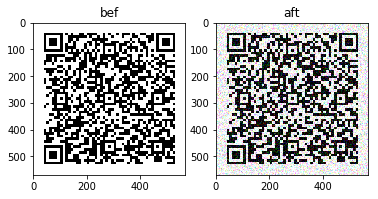

In [73]:
img = cv2.imread('bw_test.png')

plt.subplot(121), plt.imshow(img), plt.title('bef')
img = gauss_noise(img, mean=0, sigma=45)
#img = s_p_noise(img, amount = 0.002)
#img = poisson_noise(img, peak=45)
#img = speckle_noise(img, mean=0, sigma=0.5)
plt.subplot(122), plt.imshow(img), plt.title('aft')

cv2.imwrite('test.png', img)

In [232]:
o_data_ret, o_time_past = decode_color_qr('test.png', 8, 1)
print('ordinary')
print('time = ', o_time_past)
print('data length = ', len(o_data_ret),'data = ', o_data_ret)

h_data_ret, h_time_past = hard_decode_colors('test.png', 8, (5,5))
print('hard')
print('time = ', h_time_past)
print('data length = ', len(h_data_ret), 'data = ', h_data_ret)

,img_name,decoder_type,time,block_size,noise_type,noise param,yellow_qr,magenta_qr,cian_qr,decoded
1,test_0,hard,1.233014,2,gauss,5.0,1,1,1,True
2,test_0,hard,1.157331,2,gauss,5.0,1,1,1,True
3,test_0,hard,1.160686,2,gauss,5.0,1,1,1,True
4,test_0,hard,1.167579,2,gauss,5.0,1,1,1,True
5,test_0,hard,1.160121,2,gauss,5.0,1,1,1,True
6,test_0,hard,1.183020,2,gauss,5.0,1,1,1,True
7,test_0,hard,1.193378,2,gauss,5.0,1,1,1,True
8,test_0,hard,1.240319,2,gauss,5.0,1,1,1,True
9,test_0,hard,1.178849,2,gauss,5.0,1,1,1,True
10,test_0,hard,1.178052,2,gauss,5.0,1,1,1,True
